<a href="https://www.kaggle.com/code/thesoulreaper/fraud-detection-96-acc-kde-under-over-sampling?scriptVersionId=130156348" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<h1 style="text-align:center; font-family: Roboto, serif;">Credit Card Fraud Detector</h1>
<img src="https://storage.googleapis.com/kaggle-datasets-images/310/684/3503c6c827ca269cc00ffa66f2a9c207/dataset-cover.jpg" style = "align:center; margin-left:auto; margin-right:auto; width:100%">

<p style = "font-family: Roboto, serif; font-size: 1.2em; text-align: justify; font-color:gray; margin-top: 2%">The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.
<br><br>
It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.
<br><br>
Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.
</p>

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install seaborn
import seaborn as sns

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, classification_report,confusion_matrix

from sklearn.feature_selection import SelectKBest, mutual_info_classif

from sklearn.covariance import EllipticEnvelope

from sklearn.cluster import KMeans

from sklearn.preprocessing import StandardScaler, RobustScaler

from sklearn.model_selection import cross_val_score, ShuffleSplit, cross_val_predict

from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KernelDensity

pd.set_option("display.precision", 2)

scores = ["precision", "recall"]

def print_dataframe(filtered_cv_results):
    """Pretty print for filtered dataframe"""
    for mean_precision, std_precision, mean_recall, std_recall, params in zip(
        filtered_cv_results["mean_test_precision"],
        filtered_cv_results["std_test_precision"],
        filtered_cv_results["mean_test_recall"],
        filtered_cv_results["std_test_recall"],
        filtered_cv_results["params"],
    ):
        print(
            f"precision: {mean_precision:0.3f} (±{std_precision:0.03f}),"
            f" recall: {mean_recall:0.3f} (±{std_recall:0.03f}),"
            f" for {params}"
        )
    print()


def refit_strategy(cv_results):
    """Define the strategy to select the best estimator.

    The strategy defined here is to filter-out all results below a precision threshold
    of 0.96, rank the remaining by recall and keep all models with one standard
    deviation of the best by recall. Once these models are selected, we can select the
    fastest model to predict.

    Parameters
    ----------
    cv_results : dict of numpy (masked) ndarrays
        CV results as returned by the `GridSearchCV`.

    Returns
    -------
    best_index : int
        The index of the best estimator as it appears in `cv_results`.
    """
    scores = ["precision", "recall"]
    # print the info about the grid-search for the different scores
    precision_threshold = 0.96
    
    while True:
        cv_results_ = pd.DataFrame(cv_results)
        print("All grid-search results:")
        print_dataframe(cv_results_)

        # Filter-out all results below the threshold
        high_precision_cv_results = cv_results_[
            cv_results_["mean_test_precision"] > precision_threshold
        ]

        print(f"Models with a precision higher than {precision_threshold}:")
        print_dataframe(high_precision_cv_results)

        high_precision_cv_results = high_precision_cv_results[
            [
                "mean_score_time",
                "mean_test_recall",
                "std_test_recall",
                "mean_test_precision",
                "std_test_precision",
                "rank_test_recall",
                "rank_test_precision",
                "params",
            ]
        ]

        # Select the most performant models in terms of recall
        # (within 1 sigma from the best)
        best_recall_std = high_precision_cv_results["mean_test_recall"].std()
        best_recall = high_precision_cv_results["mean_test_recall"].max()
        best_recall_threshold = best_recall - best_recall_std

        high_recall_cv_results = high_precision_cv_results[
            high_precision_cv_results["mean_test_recall"] > best_recall_threshold
        ]
        print(
            "Out of the previously selected high precision models, we keep all the\n"
            "the models within one standard deviation of the highest recall model:"
        )
        print_dataframe(high_recall_cv_results)
        
        try:

            # From the best candidates, select the fastest model to predict
            fastest_top_recall_high_precision_index = high_recall_cv_results[
                "mean_score_time"
            ].idxmin()
        
        except:
            precision_threshold -= 0.02
            
        break

    print(
        "\nThe selected final model is the fastest to predict out of the previously\n"
        "selected subset of best models based on precision and recall.\n"
        "Its scoring time is:\n\n"
        f"{high_recall_cv_results.loc[fastest_top_recall_high_precision_index]}"
    )

    return fastest_top_recall_high_precision_index

import warnings
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 KB 6.1 MB/s eta 0:00:0000:01
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


# Data and EDA
<p style = "font-family: Roboto, serif; font-size: 1.2em; text-align: justify; font-color:gray; margin-top: 2%">Importing Data and performing EDA</p>

In [36]:
df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.36,-0.07,2.54,1.38,-0.34,0.46,0.24,0.10,0.36,...,-1.83e-02,2.78e-01,-0.11,0.07,0.13,-0.19,1.34e-01,-0.02,149.62,0
1,0.0,1.19,0.27,0.17,0.45,0.06,-0.08,-0.08,0.09,-0.26,...,-2.26e-01,-6.39e-01,0.10,-0.34,0.17,0.13,-8.98e-03,0.01,2.69,0
2,1.0,-1.36,-1.34,1.77,0.38,-0.50,1.80,0.79,0.25,-1.51,...,2.48e-01,7.72e-01,0.91,-0.69,-0.33,-0.14,-5.54e-02,-0.06,378.66,0
3,1.0,-0.97,-0.19,1.79,-0.86,-0.01,1.25,0.24,0.38,-1.39,...,-1.08e-01,5.27e-03,-0.19,-1.18,0.65,-0.22,6.27e-02,0.06,123.50,0
4,2.0,-1.16,0.88,1.55,0.40,-0.41,0.10,0.59,-0.27,0.82,...,-9.43e-03,7.98e-01,-0.14,0.14,-0.21,0.50,2.19e-01,0.22,69.99,0


## Data Validation
<p style = "font-family: Roboto, serif; font-size: 1.2em; text-align: justify; font-color:gray; margin-top: 2%">
We'll check the dimensions of the data and perform checks such as Redundancy, Nulls, NAs. We'll start with a summary of the data set.
</p>

In [38]:
_ = '-'
print("\nDataset size - ", df.shape)
print(_*100, end='\n\n')

print(df.info())
print(_*100, end='\n\n')

df = df.drop(columns='Time')
print('I\'ll drop the Time column as credit card default may not be associated with Time. Now we have 30 features.\n')
print(_*100, end='\n\n')

print("Lets check if there are any NULLs or NA in our dataset. Number of NA values - ",df.isna().sum().sum())
print('\nSince we don\'t have any NAs we\'ll proceed further.\n')
print(_*100, end='\n\n')

print("Also, I want to check if there are any duplicates in the dataset. Duplicates can affect our analysis.")
print("\nNumber of Duplicate rows in the data set - ", df.duplicated().sum())
df = df.drop_duplicates()
print("\nNow that we have identified the presence of duplicates in our data, I will remove the redundant rows.\n\nDataset Final Size - ", df.shape)
print(_*100, end='\n\n')

class_freq = df['Class'].value_counts()
print("Overview of distribution of Fraud and non-fraud entries in Data.\n")
print(class_freq)
print("\n% Fraud cases in the dataset - ", class_freq[1]/class_freq[0])
print(_*100, end='\n\n')

print("Let us have a look at the descriptive statistics for this data.")
df.describe(percentiles=[.01, .99]).T


Dataset size -  (275663, 30)
----------------------------------------------------------------------------------------------------

<class 'pandas.core.frame.DataFrame'>
Index: 275663 entries, 0 to 284806
Data columns (total 30 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   V1      275663 non-null  float64
 1   V2      275663 non-null  float64
 2   V3      275663 non-null  float64
 3   V4      275663 non-null  float64
 4   V5      275663 non-null  float64
 5   V6      275663 non-null  float64
 6   V7      275663 non-null  float64
 7   V8      275663 non-null  float64
 8   V9      275663 non-null  float64
 9   V10     275663 non-null  float64
 10  V11     275663 non-null  float64
 11  V12     275663 non-null  float64
 12  V13     275663 non-null  float64
 13  V14     275663 non-null  float64
 14  V15     275663 non-null  float64
 15  V16     275663 non-null  float64
 16  V17     275663 non-null  float64
 17  V18     275663 non-null  float64
 1

<p style = "font-family: Roboto, serif; font-size: 1.2em; text-align: justify; font-color:gray; margin-top: 2%">
Since all the features in this Dataset are Principal Components of the original data I don't want to start the analysis with all the columns as we don't even know what features are they principal components of. I will start by selecting a subset of features with the help of mutual_info_classif() from sklearn library.
<br><br>
Mutual information (MI) between two random variables is a non-negative value, which measures the dependency between the variables. It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency.
<br><br>
The function relies on nonparametric methods based on entropy estimation from k-nearest neighbors distances as described in <i>A. Kraskov, H. Stogbauer and P. Grassberger, “Estimating mutual information”. Phys. Rev. E 69, 2004.</i> and <i>B. C. Ross “Mutual Information between Discrete and Continuous Data Sets”. PLoS ONE 9(2), 2014.</i>. Both methods are based on the idea originally proposed in <i>L. F. Kozachenko, N. N. Leonenko, “Sample Estimate of the Entropy of a Random Vector:, Probl. Peredachi Inf., 23:2 (1987), 9-16</i>.
</p>

In [10]:
feature_selector = SelectKBest(mutual_info_classif)
feature_selected = feature_selector.fit_transform(df.drop(columns='Class'), df['Class'])

features = feature_selector.get_feature_names_out()

# print("We'll plot the selected features to check for any relations.")
# sns.pairplot(data=df, vars = features, hue='Class')

We'll plot the selected features to check for any relations.


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f0921718e50> (for post_execute):


KeyboardInterrupt: 

<p style = "font-family: Roboto, serif; font-size: 1.2em; text-align: justify; font-color:gray; margin-top: 2%">
    Given the imbalance in our dataset we have two options either to <b>UnderSample</b> or <b>OverSample</b>. I'd like to do a comparative analysis of both the techniques to get intuition about which strategy to follow.

<h1 style = "font-family: Roboto; font-color:gray; margin-top: 2%"> 1. UnderSampling</h1>
<ol style = "font-family: Roboto, serif; font-size: 1.2em; text-align: justify; font-color:gray; margin-top: 2%">
    <li>Shuffle the dataset</li>
    <li>Create a dataframe of the minority class by selecting rows from the dataset and then selectr same amount of rows from the dataset belonging to the majority class. As we already shuffled the class we can just select the first n number of rows equal to the minority ndataset.</li>
    <li>Merge both the dataset.</li>
    <li>Shuffle the latest dataset again.</li>
</ol>
</p>

In [46]:
df = df.sample(frac=1, random_state=38)

frauds = df.loc[df['Class'] == 1]
no_frauds = df.loc[df['Class']==0][:frauds.shape[0]]

norm_distributed_df = pd.concat([frauds, no_frauds], axis = 0)

new_df = norm_distributed_df.sample(frac=1, random_state = 38)

new_df = new_df.drop_duplicates()
new_df.shape

X = new_df.loc[:, features]
y = new_df.loc[:, 'Class']

ss = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=39)

print(_*100, end='\n\n')
print("Splitting the dataset into training and test data we now have - ")
print("\nTrain Size: %s" %len(y_train))
print("Test Size: %s" %len(y_test))
print(_*150, end='\n\n')
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

print("I am using Elliptic Envelope to determine outliers. However, \
it may not be the best choice here as it assumes that the underlying data is Gaussian. \
I am assuming that 10% data instances might be outliers so using contamination as 0.1 in Elliptic Envelope\n")
print(_*100, end='\n\n')
outlier_detector = EllipticEnvelope(contamination=.05)

outlier_detector.fit(X_train)

indices = outlier_detector.predict(X_train)

bool_indices = np.where(indices == 1, True, False)

X_train = X_train[bool_indices]
y_train = y_train[bool_indices]
print("After Removing the outliers we have %s data instances" %len(X_train))

----------------------------------------------------------------------------------------------------

Splitting the dataset into training and test data we now have - 

Train Size: 709
Test Size: 237
------------------------------------------------------------------------------------------------------------------------------------------------------

I am using Elliptic Envelope to determine outliers. However, it may not be the best choice here as it assumes that the underlying data is Gaussian. I am assuming that 10% data instances might be outliers so using contamination as 0.1 in Elliptic Envelope

----------------------------------------------------------------------------------------------------

After Removing the outliers we have %s data instances 673


<h2 style = "font-family: Roboto, serif; text-align: justify; font-color:gray; margin-top: 2%">Clustering</h1>

              precision    recall  f1-score   support

           0       1.00      0.65      0.79       732
           1       0.45      1.00      0.62       214

    accuracy                           0.73       946
   macro avg       0.73      0.82      0.70       946
weighted avg       0.88      0.73      0.75       946



<Axes: >

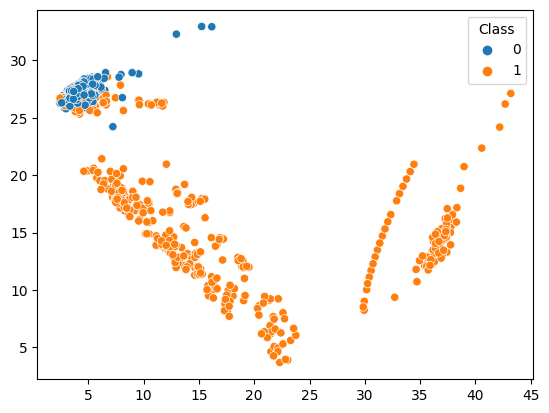

In [12]:
km = KMeans(n_clusters=2, n_init= 10, random_state=39).fit(X)
cluster = km.predict(X)

print(classification_report(cluster, y))

tc = km.fit_transform(X)

sns.scatterplot(data=tc, x=tc[:,0], y=tc[:,1], hue=y)

<p style = "font-family: Roboto, serif; font-size: 1.2em; text-align: justify; font-color:gray; margin-top: 2%">
    We can see that the Kmeans Clustering performs fairly good in identifying both the classes. It achieves 76% accuracy with undersampling method.  
</p>
<h2 style = "font-family: Roboto, serif; font-color:gray; margin-top: 5%">Model Building</h2>
<h3 style = "font-family: Roboto, serif; font-color:gray"> Undersample - SVC</h3>

In [13]:
tuned_parameters = [
    {"kernel": ["rbf"], "gamma": [1e-3, 1e-4], "C": [1, 10, 100, 1000]},
    {"kernel": ["linear"], "C": [1, 10, 100, 1000]},
]

grid_search = GridSearchCV(
    SVC(random_state = 53), tuned_parameters, scoring=scores, refit=refit_strategy
)
grid_search.fit(X_train, y_train)

print(_*100, end='\n\n')
print("Best Parameters in our Grid Search")
print(grid_search.best_params_)

print(_*100, end='\n\n')
y_pred = grid_search.predict(X_test)

print("Classification Report:\n")
print(classification_report(y_test, y_pred))

undersample_svc_model = grid_search.best_estimator_

<h2 style = "font-family: Roboto, serif; font-color:gray; margin-top: 2%">Undersample - RFC</h2>

In [15]:
tuned_parameters = [
    {"max_depth": [4,6,8]}
]

grid_search = GridSearchCV(
    RandomForestClassifier(max_samples=0.8, random_state=53), tuned_parameters, scoring=scores, refit=refit_strategy
)
grid_search.fit(X_train, y_train)

print(_*100, end='\n\n')
print("Best Parameters in our Grid Search")
print(grid_search.best_params_)

print(_*100, end='\n\n')
y_pred = grid_search.predict(X_test)

print("Classification Report:\n")
print(classification_report(y_test, y_pred))

undersample_rfc = grid_search.best_estimator_

<p style = "font-family: Roboto, serif; font-size: 1.2em; text-align: justify; font-color:gray">SVC performs better than Random Forest Classifier here as the dataset is much smaller.</p>

<h1 style = "font-family: Roboto, serif; font-color:gray;"> 2. OverSampling </h1>

<p style = "font-family: Roboto, serif; font-size: 1.2em; text-align: justify; font-color:gray; margin-top: 2%">
In order to OverSample, I am going to use Kernel density estimator to learn a non-parametric generative model of a dataset in order to efficiently draw new samples from this generative model. The Kernel function is controlled by the Bandwidth parameter. I am going to use the default setting for the kernel which is gaussian.
<br><br>
The bandwidth here acts as a smoothing parameter, controlling the tradeoff between bias and variance in the result. A large bandwidth leads to a very smooth (i.e. high-bias) density distribution. A small bandwidth leads to an unsmooth (i.e. high-variance) density distribution.
<br><br>
The parameter bandwidth controls this smoothing. One can either set manually this parameter or use Scott’s and Silvermann’s estimation methods. I am goinng to use GridSearchCV to get a good estimate for our Bandwidth parameter.
<br><br>
Instead of Full-scale oversampling the fraudulent cases I am going to draw 1000 new samples from the fraudulent cases dataset and then perform some cheecks to ensure that we have samples mimicing the original ones. After generating the new samples and concatenating the fraud and non-fraud cases at random from the original dataset, we perform feature selection with Mutual Information and perform scaaling then outlier detection with EllipticEnvelope.
    
</p>

In [48]:
params = {"bandwidth": np.logspace(-1, 1, 20)}
grid = GridSearchCV(KernelDensity(), params)
grid.fit(df.loc[df['Class']==1])

print("Best bandwidth: {0}".format(grid.best_estimator_.bandwidth))
print(_*100, end='\n\n')
# use the best estimator to compute the kernel density estimate
kde = grid.best_estimator_

latest_data = kde.sample(1000, random_state=10)
latest_df = pd.DataFrame(latest_data, columns=df.columns)
latest_df['Class'] = 1

latest_df = latest_df[latest_df['Amount']>0]

oversample = pd.concat([latest_df, df], axis =0)

oversample = oversample.sample(frac=1, random_state=38)

frauds = oversample.loc[oversample['Class'] == 1]

no_frauds = oversample.loc[oversample['Class']==0][:frauds.shape[0]]

norm_distributed_df = pd.concat([frauds, no_frauds], axis = 0)

oversample_new_df = norm_distributed_df.sample(frac=1, random_state = 38)

print('Shape of the new dataset is ', oversample_new_df.shape)
print(_*100, end='\n\n')
feature_selector = SelectKBest(mutual_info_classif)
feature_selected = feature_selector.fit_transform(oversample_new_df.drop(columns='Class'), oversample_new_df['Class'])

features = feature_selector.get_feature_names_out()

print('Features selected with Mutual Information are ',features)
print(_*100, end='\n\n')
X = oversample_new_df.loc[:, features]
y = oversample_new_df.loc[:, 'Class']

ss = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=39)

print("Splitting the dataset into training and test data we now have - ")
print("\nTrain Size: %s", len(y_train))
print("Test Size: %s", len(y_test))
print(_*150, end='\n\n')
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

print("I am using Elliptic Envelope to determine outliers. However, \
it may not be the best choice here as it assumes that the underlying data is Gaussian. \
I am assuming that 10% data instances might be outliers so using contamination as 0.1 in Elliptic Envelope")
print(_*100, end='\n\n')
outlier_detector = EllipticEnvelope(contamination=.1)

outlier_detector.fit(X_train)

indices = outlier_detector.predict(X_train)

bool_indices = np.where(indices == 1, True, False)

X_train = X_train[bool_indices]
y_train = y_train[bool_indices]

print('After removing outliers from the training dataset we now have %s training instances' %(len(y_train)))

Best bandwidth: 4.832930238571752
----------------------------------------------------------------------------------------------------

Shape of the new dataset is  (2568, 30)
----------------------------------------------------------------------------------------------------

Features selected with Mutual Information are  ['V3' 'V7' 'V10' 'V11' 'V12' 'V14' 'V16' 'V17' 'V27' 'V28']
----------------------------------------------------------------------------------------------------

Splitting the dataset into training and test data we now have - 

Train Size: %s 1926
Test Size: %s 642
----------------------------------------------------------------------------------------------------

I am using Elliptic Envelope to determine outliers. However, it may not be the best choice here as it assumes that the underlying data is Gaussian. I am assuming that 10% data instances might be outliers so using contamination as 0.1 in Elliptic Envelope
----------------------------------------------------

<h2 style = "font-family: Roboto, serif; font-color:gray; margin-top: 2%">Model Building</h2>
<h3 style = "font-family: Roboto, serif; font-color:gray"> Oversample - SVC</h3>

In [18]:
tuned_parameters = [
    {"kernel": ["rbf"], "gamma": [1e-3, 1e-4], "C": [1, 10, 100, 1000]},
    {"kernel": ["linear"], "C": [1, 10, 100, 1000]},
]

grid_search = GridSearchCV(
    SVC(random_state=53), tuned_parameters, scoring=scores, refit=refit_strategy
)
grid_search.fit(X_train, y_train)
print(_*100, end='\n')
print("\nBest Parameters in our Grid Search")
print(grid_search.best_params_)
print(_*100, end='\n')
y_pred = grid_search.predict(X_test)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

oversample_svc_model = grid_search.best_estimator_

### OverSampling - RFC

In [49]:
tuned_parameters = [
    {"max_depth": [4,6,8]}
]

grid_search = GridSearchCV(
    RandomForestClassifier(max_samples=0.8, random_state=53), tuned_parameters, scoring=scores, refit=refit_strategy
)
grid_search.fit(X_train, y_train)
print(_*100, end='\n')
print("Best Parameters in our Grid Search")
print(grid_search.best_params_)
print(_*100, end='\n')
y_pred = grid_search.predict(X_test)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

oversample_rfc = grid_search.best_estimator_

All grid-search results:
precision: 0.983 (±0.009), recall: 0.934 (±0.019), for {'max_depth': 4}
precision: 0.981 (±0.012), recall: 0.938 (±0.018), for {'max_depth': 6}
precision: 0.977 (±0.014), recall: 0.939 (±0.017), for {'max_depth': 8}

Models with a precision higher than 0.96:
precision: 0.983 (±0.009), recall: 0.934 (±0.019), for {'max_depth': 4}
precision: 0.981 (±0.012), recall: 0.938 (±0.018), for {'max_depth': 6}
precision: 0.977 (±0.014), recall: 0.939 (±0.017), for {'max_depth': 8}

Out of the previously selected high precision models, we keep all the
the models within one standard deviation of the highest recall model:
precision: 0.981 (±0.012), recall: 0.938 (±0.018), for {'max_depth': 6}
precision: 0.977 (±0.014), recall: 0.939 (±0.017), for {'max_depth': 8}


The selected final model is the fastest to predict out of the previously
selected subset of best models based on precision and recall.
Its scoring time is:

mean_score_time                    0.02
mean_test_recall

<p style = "font-family: Roboto, serif; font-size: 1.2em; text-align: justify; font-color:gray; margin-top: 2%">
We can see that Random Forests work better with more samples wheras SVC has much or less similar performance in both the cases as sample increases but not by much in the second case.
</p>
<h1 style = "font-family: Roboto, serif; font-color:gray">Thank You</h1>